<a href="https://colab.research.google.com/github/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/blob/main/2_Simple_encoder_decoder_Medical_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
image_folder = 'NLMCXR_png'
df_path = 'df_final.pkl'

In [5]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
import os
import math

# **Creating Tokenizer**

In [6]:
df = pd.read_pickle(df_path)
col = ['image_1','image_2','impression','xml file name']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = '<CLS> ' + df.impression + ' <END>'
df['impression_ip'] = '<CLS> ' + df.impression
df['impression_op'] = df.impression + ' <END>' 
print(df.shape)
df.head(2)

(4033, 7)


,image_1,image_2,impression,xml file name,impression_final,impression_ip,impression_op
0,NLMCXR_png/CXR2593_IM-1084-1001.png,NLMCXR_png/CXR2593_IM-1084-2001.png,mild cardiomegaly with interstitial prominence...,2593.xml,<CLS> mild cardiomegaly with interstitial prom...,<CLS> mild cardiomegaly with interstitial prom...,mild cardiomegaly with interstitial prominence...
1,NLMCXR_png/CXR2201_IM-0811-1002.png,NLMCXR_png/CXR2201_IM-0811-1002.png,no acute cardiopulmonary abnormality . .,2201.xml,<CLS> no acute cardiopulmonary abnormality . ....,<CLS> no acute cardiopulmonary abnormality . .,no acute cardiopulmonary abnormality . . <END>


In [7]:
df['impression'].value_counts()

no acute cardiopulmonary abnormality .                                                                                                383
no acute cardiopulmonary findings .                                                                                                   172
no acute cardiopulmonary disease .                                                                                                    147
no acute cardiopulmonary abnormalities .                                                                                              141
no active disease .                                                                                                                   137
                                                                                                                                     ... 
mild chronic changes in the left lung base without acute disease .                                                                      1
minimal atelectasis platelike in t

Here we can see that some captions have only 1 values in the entire dataset while some datasets are having more than 5. What I will do here is that I will upsample all those datapoint which impression value counts <=5. First I will remove all those datapoints which are duplicated based on xml file name(ie of the same patient because some patients are having more than 2 images) and then split the data into train and test.

In [8]:
df.drop_duplicates(subset = ['xml file name'], inplace = True)

In [9]:
#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = df['impression'].value_counts()
df = df.merge(k,
         left_on = 'impression',
         right_index=True) #join left impression value with right index

df.columns

Index(['impression', 'image_1', 'image_2', 'impression_x', 'xml file name',
       'impression_final', 'impression_ip', 'impression_op', 'impression_y'],
      dtype='object')

In [10]:
df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final',
       'impression_ip', 'impression_op', 'impression_counts'] #changin column names
del df['impression_x'] #deleting impression_x column
df.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,mild cardiomegaly with interstitial prominence...,NLMCXR_png/CXR2593_IM-1084-1001.png,NLMCXR_png/CXR2593_IM-1084-2001.png,2593.xml,<CLS> mild cardiomegaly with interstitial prom...,<CLS> mild cardiomegaly with interstitial prom...,mild cardiomegaly with interstitial prominence...,1
1,no acute cardiopulmonary abnormality . .,NLMCXR_png/CXR2201_IM-0811-1002.png,NLMCXR_png/CXR2201_IM-0811-1002.png,2201.xml,<CLS> no acute cardiopulmonary abnormality . ....,<CLS> no acute cardiopulmonary abnormality . .,no acute cardiopulmonary abnormality . . <END>,43
45,no acute cardiopulmonary abnormality . .,NLMCXR_png/CXR1047_IM-0036-1001.png,NLMCXR_png/CXR1047_IM-0036-2001.png,1047.xml,<CLS> no acute cardiopulmonary abnormality . ....,<CLS> no acute cardiopulmonary abnormality . .,no acute cardiopulmonary abnormality . . <END>,43
66,no acute cardiopulmonary abnormality . .,NLMCXR_png/CXR1425_IM-0272-1001.png,NLMCXR_png/CXR1425_IM-0272-1002.png,1425.xml,<CLS> no acute cardiopulmonary abnormality . ....,<CLS> no acute cardiopulmonary abnormality . .,no acute cardiopulmonary abnormality . . <END>,43
167,no acute cardiopulmonary abnormality . .,NLMCXR_png/CXR2786_IM-1221-1001.png,NLMCXR_png/CXR2786_IM-1221-2001.png,2786.xml,<CLS> no acute cardiopulmonary abnormality . ....,<CLS> no acute cardiopulmonary abnormality . .,no acute cardiopulmonary abnormality . . <END>,43


In [11]:
from sklearn.model_selection import train_test_split
other1 = df[df['impression_counts']>5] #selecting those datapoints which have impression valuecounts >5
other2 = df[df['impression_counts']<=5] #selecting those datapoints which have impression valuecounts <=5
train,test = train_test_split(other1,stratify = other1['impression'].values,test_size = 0.1,random_state = 420)
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 420) #getting some datapoints from other2 data for test data
other2 = other2.drop(test_other2_sample.index,axis=0)
#here i will be choosing 0.5 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

train = train.append(other2) 
train = train.reset_index(drop=True)
train.shape[0],test.shape[0]

(3257, 563)

upsample and downsample certain datapooints.

In [12]:
from sklearn.utils import resample
df_majority = train[train['impression_counts']>=100] #having value counts >=100
df_minority = train[train['impression_counts']<=5] #having value counts <=5
df_other = train[(train['impression_counts']>5)&(train['impression_counts']<100)] #value counts between 5 and 100
n1 = df_minority.shape[0]
n2 = df_majority.shape[0]
n3 = df_other.shape[0]
#we will upsample them to 30
df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(df_majority,
                                 replace = False,
                                 n_samples = n2//15,
                                 random_state = 420)
df_other_downsampled = resample(df_other,
                                 replace = False,
                                 n_samples = n3//10,
                                 random_state = 420)

train = pd.concat([df_majority_downsampled ,df_minority_upsampled,df_other_downsampled])
train = train.reset_index(drop=True)
# del df_minority_upsampled,df_minority,df_majority,df_other,df_other_downsampled
train.shape

(4487, 8)

In [13]:
train.impression.value_counts()

comparison well expanded and clear lungs . mediastinal contour within normal limits . no acute cardiopulmonary abnormality identified .                                                                                                                                                                                                             27
no acute cardiopulmonary abnormality .                                                                                                                                                                                                                                                                                                              17
no evidence of acute cardiopulmonary process . stable appearance of the chest .                                                                                                                                                                                                                                           

In [15]:
folder_name = ''
file_name = 'train.pkl'
train = pd.read_pickle(os.path.join(folder_name,file_name))

file_name = 'test.pkl'
test = pd.read_pickle(os.path.join(folder_name,file_name))

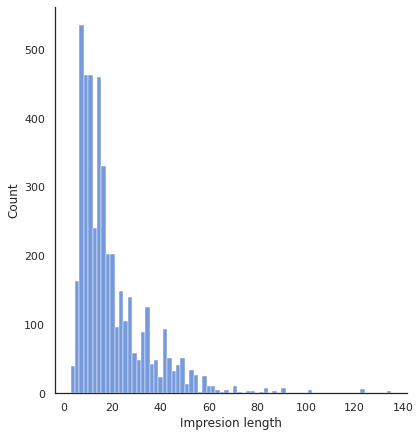


Value Counts for caption length top 5 values

Length|Counts
8     272
7     263
10    254
13    240
15    234
dtype: int64

The max and min value of "caption length" was found to be 135 and 3 respectively
The 80 percentile value of caption_len which is 28 will be taken as the maximum padded value for each impression


In [16]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>

#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 80 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,80)))
max_pad = int(np.percentile(caption_len,80))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader

# **Modelling**

## **Hyperparameters**

In [17]:
batch_size = 10
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

## **Creating an input data pipeline**

In [18]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically


  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present

    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.333:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.667:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] #getting the shuffled index values
        data = [self.dataset[j] for j in indexes] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            np.random.shuffle(self.indexes) #in-place shuffling takes place

In [19]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

## **CHeXNET Model (random weights)**

[CheXNET Model](https://arxiv.org/pdf/1711.05225.pdf) is a Denset121 layered model 

In [20]:
#chexnet weights ; https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view
def create_chexnet():
  """
  creates a chexnet model with random weights
  """
  model = tf.keras.applications.DenseNet121(include_top=False) #importing densenet the last layer will be a relu activation layer
  #we need to load the weights so setting the architecture of the model as same as the one of tha chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper
  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-2].output)  #we will be taking the penultimate layer (second last layer here it is global avgpooling)
  return chexnet

In [21]:
chexnet = create_chexnet()
chexnet.trainable = True

tf.keras.utils.plot_model(
    chexnet,
    to_file="model_1.png",
    show_shapes=True,
)

2021-11-11 07:41:41.153931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 07:41:41.154324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 07:41:41.207347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ozkilim/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/x86_64-linux-gnu:/usr/local/cuda/lib64:/usr/local/lib/
2021-11-11 07:41:41.207363: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed pro

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Simple Encoder Decoder Model

### Image Encoder Layer

In [22]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.chexnet = create_chexnet()
    self.chexnet.trainable = True

  def call(self,data):
    op = self.chexnet(data)
    return op

### Model

In [23]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [24]:
glove = {}
with open('glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

In [25]:
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))

img_encoder = Image_encoder() #contains chexnet model which is set trainable  =  True
bk_feat1 = img_encoder(image1)

bk_feat2 = img_encoder(image2)

bk_features_concat = Concatenate(axis=-1)([bk_feat1,bk_feat2]) #concatenating the backbone images op_shape: (?,1024)

image_dense = Dense(dense_dim,
                    activation = 'relu',
                    name = 'Image_dense',
                    use_bias='False'

                    )
                    
image_bkbone = image_dense(bk_features_concat) #final op from dense op_shape: (?,dense_dim) this will be added as initial states to the lstm
image_dense_op = tf.keras.backend.expand_dims(image_bkbone,axis=1) #op_shape: (?,1,dense_dim)

embedding = Embedding(input_dim  = vocab_size+1,
                              output_dim = embedding_dim,
                              input_length = max_pad,
                              mask_zero = True,
                              weights = [embedding_matrix],
                              name = 'embedding'
                              )
embed_op = embedding(caption) #op_shape: (?,input_length,embedding_dim)

lstm_layer = LSTM(units = lstm_units,
                  return_sequences= True,
                  return_state = True     
                  )
lstm_op,lstm_h,lstm_c = lstm_layer(embed_op,initial_state = [image_bkbone,image_bkbone]) #op_shape = batch_size*input_length*lstm_units

# lstm_op = BatchNormalization()(lstm_op)
add = Add()([image_dense_op,lstm_op]) #op_shape: (?,input_lenght,lstm_units/dense_dim) here lstm_dims=dense_dim

op_dense = Dense(vocab_size+1,
                 activation = 'softmax',
                 name = 'output_dense'
                 ) #op: (?,input_length,vocab_size+1)

output = op_dense(add)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
image_encoder (Image_encoder)   (None, 1024)         7037504     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 2048)         0           image_encoder[0][0]        

In [27]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [28]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [29]:
tf.keras.backend.clear_session()
tb_filename = ''
tb_file = os.path.join('',tb_filename)
model_filename = 'Baseline_Encoder_Decoder.h5'
model_save = os.path.join('',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

2021-11-11 07:42:06.367694: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-11 07:42:06.367720: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-11 07:42:06.368873: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2021-11-11 07:42:06.369203: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ozkilim/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/x86_64-linux-gnu:/usr/local/cuda/lib64:/usr/local/lib/
2021-11-11 07:42:06.415763: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-11 07:42:06.415918: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [30]:
# model.fit(train_dataloader,
#           validation_data = test_dataloader,
#           epochs = 3,
#           callbacks = my_callbacks
#           )

# # create file first then open and dump

# model_filename = 'Baseline_Encoder_Decoder.h5'
# model_save = os.path.join('',model_filename)
# model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
# model1.load_weights(model_save)

In [32]:
model_filename = './trained_models/Baseline_Encoder_Decoder.h5'
model_save = os.path.join('',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

## **Predictions**

We will compute bleu scores 1-gram,2-gram, 3-gram and 4-gram for each sentence.

In [33]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0),)
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [34]:
#calculate bleu scores for every datapoint
def mean_bleu(test,predict,model=model1,**kwargs):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  if kwargs!=None:
    top_k = kwargs.get('top_k')
  else:
    top_k = None
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in test.iterrows():
    if top_k==None:
      predict_val = predict(data['image_1'],data['image_2'],model = model) #predicted sentence
    else:
      predict_val = predict(data['image_1'],data['image_2'],model = model,top_k = top_k)
    true = data.impression
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()

### **Greedy Search**

In [35]:
def greedy_search_predict(image1,image2,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)
  

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder')(image2)

  # image1 = model.get_layer('bk_dense')(image1) #op from dense layer
  # image2 = model.get_layer('bk_dense')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  image_dense = model.get_layer('Image_dense')(concat)
  # concat = model.get_layer('batch_normalization')(concat)
  # image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = tf.keras.backend.expand_dims(image_dense,axis=1)


  states = [image_dense, image_dense]
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    caption= model.get_layer('embedding')(caption) #embedding shape = 1*1*300
    caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states) #lstm 1*1*512
    states = [state_h,state_c]

    add = model.get_layer('add')([bk_feat,caption]) #add
    output = model.get_layer('output_dense')(add) #1*1*vocab_size (here batch_size=1)

    #prediction
    max_prob = tf.argmax(output,axis=-1) #tf.Tensor of shape = (1,1)
    caption = np.array(max_prob) #will be sent to embedding for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array

In [36]:
%%time
k=-1
image1,image2 = test['image_1'].iloc[k],test['image_2'].iloc[k]
print(greedy_search_predict(image1,image2,model=model))

no acute cardiopulmonary process <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . calcified left lateral rib fractures . <unk> . <unk> .
CPU times: user 840 ms, sys: 32.3 ms, total: 872 ms
Wall time: 489 ms


In [37]:
%%time
_ = mean_bleu(test,greedy_search_predict)

CPU times: user 7min 25s, sys: 15 s, total: 7min 40s
Wall time: 3min 35s


In [38]:
k = list(_)
index = 'greedy search'
result = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])

In [39]:
result

,bleu1,bleu2,bleu3,bleu4
greedy search,0.11906,0.045302,0.020128,0.005991


### **Beam Search**

In [40]:
def encoder_op(image1,image2,model = model1):
  """
  Given image1 and image2 filepath, outputs
  their backbone features which will be input
  to the decoder
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255

  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = tf.keras.backend.expand_dims(image_dense,axis=1)
  states = [image_dense, image_dense]
  return bk_feat,states

In [41]:
def beam_search_predict(image1,image2,top_k=3,max_pad = max_pad,model = model1):
  """
  Given image1, image2 get the top
  beam search predicted sentence
  """
  k = top_k
  cls_token = tokenizer.texts_to_sequences(['<cls>'])[0] #[3]
  bk_feat,states = encoder_op(image1,image2)
  seq_score = [[cls_token,0,states]] #[[[3], 0]]
  finished_seq_score = []
  for i in range(max_pad): #traverse through all lengths
    all_candidates = [] #stores all the top k seq along with their scores
    new_seq_score = [] #stores the seq_score which does not have <end> in them
    for s in seq_score: #traverse for all top k sequences
      text_input = s[0][-1] #getting the last predicted output
      # print(s)
      states = s[2]
      caption = model.get_layer('embedding')(np.array([[text_input]])) #ip must be in shape (batch_size,seq length,dim)
      caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states)
      states = [state_h,state_c]
      add = model.get_layer('add')([bk_feat,caption])
      output = model.get_layer('output_dense')(add)[0][0] #(vocab_size,)
      top_words = tf.argsort(output,direction = 'DESCENDING')[:k] #get the top k words

      seq,score,_ = s
      for t in top_words.numpy():
        #here we will update score with log of probabilities and subtracting(log of prob will be in negative)
        #here since its -(log), lower the score higher the prob
        candidates = [seq+[t],score-np.log(output[t].numpy()),states] #updating the score and seq
        all_candidates.append(candidates)
      seq_score = sorted(all_candidates,key = lambda l:l[1])[:k] #getting the top 3 sentences with high prob ie low score
      #checks for  <end> in each seq obtained
      count = 0
      end_token = tokenizer.word_index['<end>']
      for seq,score,state in seq_score:
        # print('seq,score',seq,score)
        if seq[-1] == end_token: #if last word of the seq is <end>
          finished_seq_score.append([seq,score])
          count+=1
        else:
          new_seq_score.append([seq,score,state])
      k-=count #substracting the no. of finished sentences from beam length
      seq_score = new_seq_score

      if seq_score==[]: #if null array
        break;
      else:
        continue;

  seq_score = finished_seq_score[-1]
  sentence = seq_score[0][1:-1] #here <cls> and <end> is here so not considering that
  score = seq_score[1]
      
  return tokenizer.sequences_to_texts([sentence])[0]

In [43]:
%%time
k=-1
image1,image2 = test['image_1'].iloc[k],test['image_2'].iloc[k]
print(beam_search_predict(image1,image2,top_k = 3))
_ = mean_bleu(test,beam_search_predict)

KeyboardInterrupt: 

In [ ]:
%%time


In [ ]:
k = list(_)
index = 'beam search (top_k = 3)'
temp = pd.DataFrame([k],columns = ["bleu1","bleu2","bleu3","bleu4"],index = [index])
result = result.append(temp)
result

Error: Kernel is dead

The bleu scores of both greedy search and beam search (top_k = 3) is found to be similiar so we can say that the best model will be based on greedy search for the simple encoder decoder model since it is the fastest. Finding bleu score for top_k = 5 was found to be very slow so it was discarded.

# **Inference**

Now we will predict all datapoints with best approach chosen (here it is greedy search) and see the results manually and also compute bleu (1 gram) score.

In [44]:
%%time
test['bleu_1_gs'] = np.zeros(test.shape[0]) #greedy search
test['bleu_1_bm'] = np.zeros(test.shape[0]) #beam search
test['prediction_gs'] = np.zeros(test.shape[0]) #greedy search
test['prediction_bm'] = np.zeros(test.shape[0]) #beam search
for index,rows in test.iterrows():
  #greedy search
  predicted_text = greedy_search_predict(rows.image_1,rows.image_2,model1)
  test.loc[index,'prediction_gs'] = predicted_text
  reference = [rows['impression'].split()]
  test.loc[index,'bleu_1_gs'] = sentence_bleu(reference,predicted_text.split(),weights = (1,0,0,0))

  #beam search
  predicted_text = beam_search_predict(rows.image_1,rows.image_2,top_k = 3,model = model1)
  test.loc[index,'prediction_bm'] = predicted_text
  test.loc[index,'bleu_1_bm'] = sentence_bleu(reference,predicted_text.split(),weights = (1,0,0,0))

KeyboardInterrupt: 

In [ ]:
test['prediction_gs'].value_counts()*100/test.shape[0] #greedy search

no acute cardiopulmonary abnormality .    100.0
Name: prediction_gs, dtype: float64

In [ ]:
test['prediction_bm'].value_counts()*100/test.shape[0] #beam search

no acute cardiopulmonary abnormality .    100.0
Name: prediction_bm, dtype: float64

From the above results, we can see that for every datapoint the model is predicting "no acute cardiopulmonary abnormality" suggesting the model has overfitted.

## Random predictions on test data

In [45]:
def final_caption_pred(image1,image2,method = "beam",top_k = 3,model=model1):
  """
  Given image1. image2 paths, the model, top_k and the method of prediction returns the predicted caption
  method: "greedy" or "g" for greedy search, "beam" or "b" for beam search
  """
  if method in ['greedy','g']:
    pred_caption = greedy_search_predict(image1,image2,model)
  elif method in ['beam','b']:
    pred_caption = beam_search_predict(image1,image2,top_k = top_k,model = model)
  else:
    print("Enter 'b' or 'beam' for beam search and 'g' or 'greedy' for greedy search")
  
  return pred_caption

In [46]:
def inference(image1,image2,true_caption,model=model1,top_k = [3],image_size = (10,20)):
  """
  given 2 images (their paths), the true caption, the model and the range of top_k
  prints the two images, true caption along with greedy search prediction and beam search prediction of top_k range
  """
  image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
  image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
  if type(top_k)==int:
    top_k = [top_k] #changing it to list if top_k given is of int type
  greedy_caption = final_caption_pred(image1,image2,method='g',model=model) #getting the greedy search prediction

  #printing the 2 images
  plt.figure(figsize = image_size)
  plt.subplot(121)
  plt.imshow(image1_array)
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(image2_array)
  plt.axis("off")
  plt.show()

  print("\nTrue caption: '%s'"%(true_caption))
  print("Predicted caption(greedy search): '%s'"%(greedy_caption))
  #beam search of top_k
  if top_k != None:
    for i in top_k:
      beam_caption = final_caption_pred(image1,image2,method='b',model=model,top_k = i)
      print("Predicted caption(beam search = %i): '%s'"%(i,beam_caption))


### Correct Captions

In [48]:
i = test[test['bleu_1_gs']>0.8].sample(5).index
for k in i:
  image1,image2 = test['image_1'][k],test['image_2'][k]
  true_caption = test['impression'][k]
  inference(image1,image2,true_caption)

ValueError: a must be greater than 0 unless no samples are taken

### Incorrect Caption

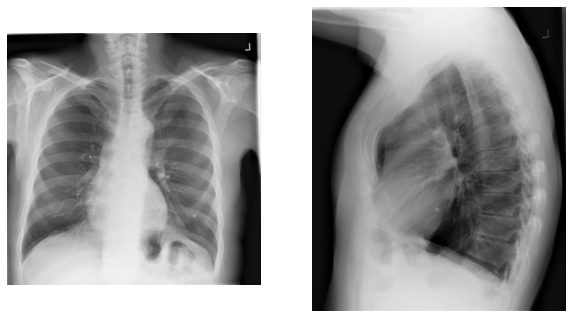


True caption: 'no evidence of active disease . evidence of previous granulomatous infection . pectus carinatum .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk>'


KeyboardInterrupt: 

In [49]:
i = test[test['bleu_1_gs']<0.3].sample(5).index
for k in i:
  image1,image2 = test['image_1'][k],test['image_2'][k]
  true_caption = test['impression'][k]
  inference(image1,image2,true_caption)

Even after upsampling and downsampling various datapoints so as to make sure that there is variablity in the data the model is performing not good suggesting that we need more data with much more variability in the results ie X-rays of patients that have disease. Since this is a baseline model we will try creating other models and compare the results. And also we can see how bleu score as metric cannot be trusted blindly. We need to check manually to understand whether the model is doing a very good predicition or not.

# For comparisons

We will ignore the results of beam search as the predicition is same as that of greedy search.

For comparing the results with other results, we willl predict captions on 3 train data and 3 test data.

## Train

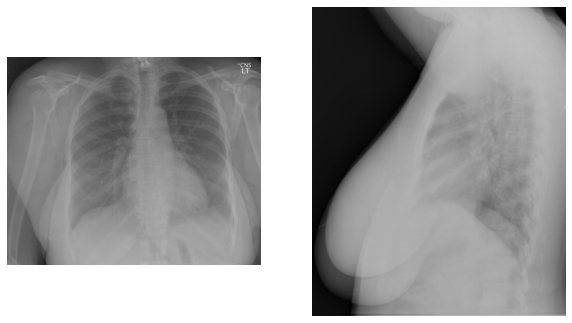


True caption: 'left basilar atelectasis . no focal airspace consolidation .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality . <unk> left knee . negative for further evaluation . <unk> left ankle . <unk> left basilar atelectasis . <unk> left basilar atelectasis .'


In [50]:
k = 100
image1,image2 = train['image_1'][k],train['image_2'][k]
true_caption = train['impression'][k]
inference(image1,image2,true_caption,top_k = None)

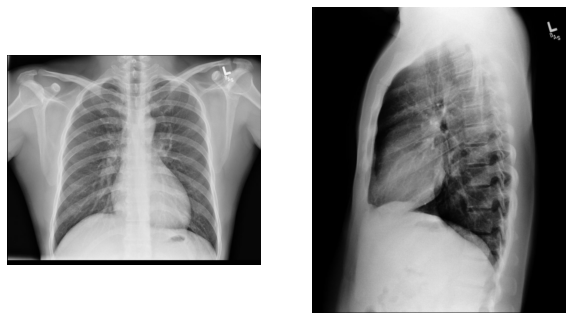


True caption: 'normal heart size . normal pulmonary vasculature . normal mediastinal contours . lung parenchyma is clear . no airspace disease . no pulmonary edema . no of pleural effusions . no of active tuberculosis . no of active cardiopulmonary disease .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . calcified left lateral rib fractures . <unk> . <unk> . <unk>'


In [51]:
k = 1000
image1,image2 = train['image_1'][k],train['image_2'][k]
true_caption = train['impression'][k]
inference(image1,image2,true_caption,top_k = None)

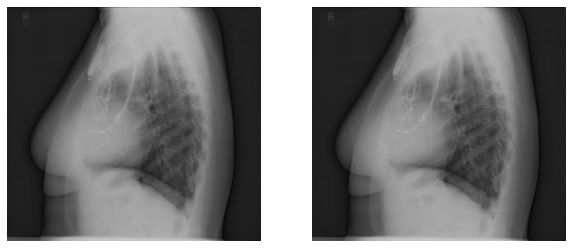


True caption: 'the remain intact and the prosthetic pulmonic valve is unchanged in position . a fourth remains disrupted . there is persistent mild to moderate cardiomegaly . the lungs appear clear .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk>'


In [52]:
k = 4000
image1,image2 = train['image_1'][k],train['image_2'][k]
true_caption = train['impression'][k]
inference(image1,image2,true_caption,top_k = None)

## Test

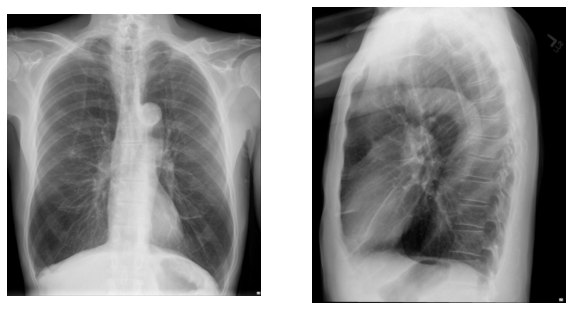


True caption: 'hyperexpanded but clear lungs .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk>'


In [53]:
k = 160
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption,top_k = None)

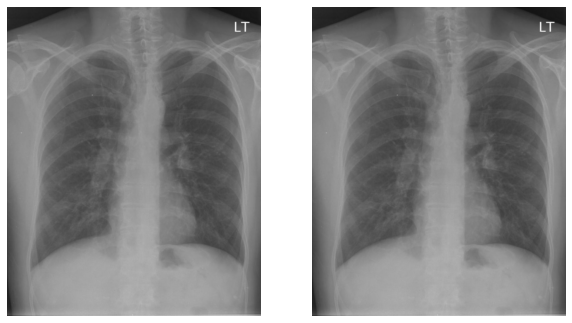


True caption: 'heart size is normal . left midlung small calcified granulomas unchanged . persistent partial middle lobe atelectasis and infiltrate seen on the lateral'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk> . <unk>'


In [54]:
k = 290
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption,top_k = None)

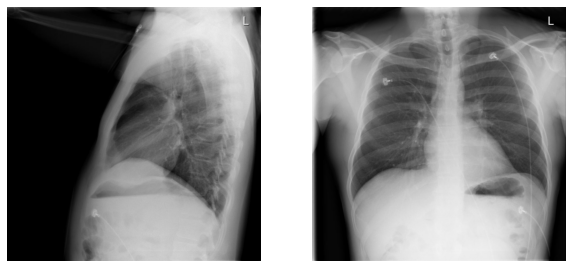


True caption: 'no acute cardiopulmonary disease .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality . <unk> no evidence of active tuberculous process . <unk> no acute pulmonary process . <unk> no displaced fractures . <unk> no acute bony'


In [55]:
k = 25
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption,top_k = None)

Even in train data the model is predicting "no acute cardiopulmonary abnormality". We can set this as the baseline model.

# Conclusion

In [ ]:
result

,bleu1,bleu2,bleu3,bleu4
greedy search,0.317412,0.308454,0.333496,0.366244
beam search (top_k = 3),0.317412,0.308454,0.333496,0.366244


The baseline model had similar bleu scores for both greedy search and beam search(top_k = 3). It was found that for top_k = 5,7 the model took a lot of time in predicting so it was discarded. The model outputted the same caption for every test and train data suggesting a better variability of data might improve the model performance. We will compare the results of this baseline model with other models.
